The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


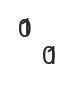

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE, PairedFVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss
from src.datasets import CDR3BetaDataset, PairedDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [11]:
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df.head()

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,TRA_CDR3,TRB_CDR3
0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,1,KLGGALQAK,KLGGALQAK,TRAV30*01,...,TRBJ2-5*01,2,32208.0,HLA-A*03:01,10x,2627.0,TRBV27,TRBJ2-5,CGTEIGGGTSYGKLTF,CASGTETQYF
1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-3*01,3,37123.0,HLA-A*02:01,10x,3820.0,TRBV20-1,TRBJ2-3,CAVNPANARLMF,CSARWGGGTDTQYF
2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,TRBJ2-7*01,3,14961.0,HLA-A*11:01,10x,3592.0,TRBV20-1,TRBJ2-7,CAVGDDKIIF,CSARGLDRGTNEQYF
3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-7*01,0,8197.0,HLA-A*02:01,10x,5933.0,TRBV3-1,TRBJ2-7,CAVTPGTYKYIF,CASSPGTSIFVAEQYF
4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,TRBJ2-4*01,1,23616.0,HLA-B*08:01,10x,2745.0,TRBV12-4,TRBJ2-4,CAFLYNQGGKLIF,CASSPGSRGNIQYF


In [51]:
def get_cluster_stats(input_df, cluster='KMeans_Cluster', label='GroundTruth', feature='TSNE_1', kf=True):


    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            l = len(df)
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            summary['retention'] = (100 * summary['cluster_size']) / l
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        l = len(df)
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        summary['retention'] = 100 * summary['cluster_size'] / l
        return summary, df

In [79]:
summary_dfs_all = pd.read_csv('../output/cluster_analysis/summary_dfs_all.csv')
summary_dfs_top10 = pd.read_csv('../output/cluster_analysis/summary_dfs_top10.csv')

In [80]:
summary_dfs_all.head()

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
0,0,KLGGALQAK,19.512195,164,0,train,ClXaM,2.581458
1,1,KLGGALQAK,16.317992,239,0,train,ClXaM,3.762002
2,2,GILGFVFTL,27.391304,230,0,train,ClXaM,3.620337
3,3,AVFDRKSDAK,14.093960,149,0,train,ClXaM,2.345349
4,4,GILGFVFTL,16.528926,121,0,train,ClXaM,1.904612


In [ ]:
summ

In [ ]:
addpep_dataset = CDR3BetaDataset(df, max_len=23, cdr3b_col='TRB_CDR3', add_pep=True, 

In [20]:
from src.models import PairedFVAE
model = PairedFVAE()

True

# TCR pepkernel similarity adj matrix

In [26]:
adj_matrix = pd.read_csv('../data/filtered/230929_nettcr_pos_adj_matrix.csv', index_col='A')
adj_matrix.head()

,CAAGDANTGELFF,CAAGGGGTEKLFF,CAAGQGNTGELFF,CAAGSSGNQPQHF,CAAGTRTDTQYF,CAAGTSGRVGEQFF,CAAGWGIGTEAFF,CAAQNGNPNEKLFF,CAASGRASETQYF,CACPPEEGGHYGYTF,...,CSVYLNTEAFF,CSYSAGEDQPQHF,CTSIAPIF,CTSKSGGPYEQF,CTSRDLGVWTEAF,CTSVPAAWDGASSYEQYF,CTSVPAVTVNFYGYTF,CTTSSGEADTQYF,CVPPYEKLTF,CVTGQGDINEQFF
A,,,,,,,,,,,,,,,,,,,,,
CAAGDANTGELFF,1.000000,0.833791,0.922672,0.808271,0.821413,0.832520,0.803848,0.805701,0.829519,0.698965,...,0.790501,0.772687,0.746653,0.785362,0.773166,0.716327,0.723947,0.820330,0.724117,0.820758
CAAGGGGTEKLFF,0.833791,1.000000,0.862865,0.797381,0.783272,0.818931,0.821764,0.771142,0.806494,0.682179,...,0.726746,0.737543,0.697982,0.788385,0.729241,0.676698,0.669484,0.771741,0.688156,0.780579
CAAGQGNTGELFF,0.922672,0.862865,1.000000,0.816436,0.808641,0.844086,0.814680,0.810145,0.820164,0.703386,...,0.772854,0.766710,0.725283,0.793320,0.756344,0.695332,0.705312,0.804836,0.710612,0.839774
CAAGSSGNQPQHF,0.808271,0.797381,0.816436,1.000000,0.800289,0.827664,0.754594,0.786589,0.836283,0.693642,...,0.733826,0.834720,0.713450,0.814682,0.726523,0.708205,0.680435,0.811575,0.698343,0.781084
CAAGTRTDTQYF,0.821413,0.783272,0.808641,0.800289,1.000000,0.819381,0.778730,0.758944,0.866828,0.677029,...,0.802260,0.779109,0.761954,0.786587,0.782478,0.706870,0.730053,0.848794,0.744953,0.794340


In [30]:
top10_pep = df.groupby(['peptide']).agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
top10_cdr3 = df.query('peptide in @top10_pep')['TRB_CDR3'].unique()
adj_top10 = adj_matrix.loc[top10_cdr3][top10_cdr3]

### spectral

In [32]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(26, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc = sc.fit_predict(adj_matrix)
sc = SpectralClustering(10, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc_top10 = sc.fit_predict(adj_top10)

In [59]:
sc_df = pd.DataFrame(np.array([adj_matrix.index, labels_sc]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df = pd.merge(df, sc_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary, sc_cluster_df = get_cluster_stats(sc_df, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

sc_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_sc_top10]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df_top10 = pd.merge(df, sc_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary_top10, sc_cluster_df_top10 = get_cluster_stats(sc_df_top10, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

### k-means

In [39]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import KMeans
km = KMeans(26, n_init=50, max_iter=500)
labels_km = km.fit_predict(adj_matrix)
km = KMeans(10, n_init=50, max_iter=500)
labels_km_top10 = km.fit_predict(adj_top10)

In [60]:
km_df = pd.DataFrame(np.array([adj_matrix.index, labels_km]).T, columns = ['TRB_CDR3', 'km_label'])
km_df = pd.merge(df, km_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary, km_cluster_df = get_cluster_stats(km_df, cluster='km_label', label='peptide', feature = 'B3', kf=False)

km_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_km_top10]).T, columns = ['TRB_CDR3', 'km_label'])
km_df_top10 = pd.merge(df, km_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary_top10, km_cluster_df_top10 = get_cluster_stats(km_df_top10, cluster='km_label', label='peptide', feature = 'B3', kf=False)

In [62]:
display(sc_summary_top10)
display(km_summary_top10)

,sc_label,peptide,purity_percent,cluster_size,partition,retention
0,0,GILGFVFTL,25.986842,608,ALL,11.215643
1,1,GILGFVFTL,26.682692,416,ALL,7.673861
2,2,KLGGALQAK,23.750000,480,ALL,8.854455
3,3,IVTDFSVIK,17.325800,531,ALL,9.795241
4,4,GILGFVFTL,35.205479,730,ALL,13.466150
5,5,RAKFKQLL,31.319555,629,ALL,11.603025
6,6,RAKFKQLL,21.386139,505,ALL,9.315624
7,7,GILGFVFTL,19.646799,453,ALL,8.356392
8,8,KLGGALQAK,20.000000,510,ALL,9.407858
9,9,RAKFKQLL,19.499106,559,ALL,10.311751


,km_label,peptide,purity_percent,cluster_size,partition,retention
0,0,GILGFVFTL,23.869347,398,ALL,7.341819
1,1,RAKFKQLL,18.454936,466,ALL,8.596200
2,2,GILGFVFTL,33.050847,708,ALL,13.060321
3,3,RAKFKQLL,25.901639,915,ALL,16.878805
4,4,GILGFVFTL,43.193069,808,ALL,14.904999
5,5,AVFDRKSDAK,23.863636,88,ALL,1.623317
6,6,IVTDFSVIK,18.620690,435,ALL,8.024350
7,7,KLGGALQAK,20.033389,599,ALL,11.049622
8,8,KLGGALQAK,20.309051,453,ALL,8.356392
9,9,KLGGALQAK,17.967332,551,ALL,10.164176


# Meta analysis
Here, take only one fold that trained "well" (without spikes)

Only one hyperparams: 64 latent, wd = 1e-4, 10k epochs

--> Take fold that is stable, compare test and train latent for GILGFVCTL (pos and true negs)

In [90]:
summary_dfs_top10.query('set=="valid" and purity_percent>50 and cluster_size>12').groupby('run_id')\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

,count
run_id,
KtR1W,5
NnzVv,5
x8CyX,5
3jETu,4
A0dGE,3


In [89]:
summary_dfs_all.query('set=="valid" and purity_percent>75 and cluster_size>10').groupby('run_id')\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

,count
run_id,
A0dGE,5
KtR1W,5
3jETu,4
B6jIc,4
NnzVv,4


In [86]:
summary_dfs_all.query('run_id=="KtR1W" and set=="valid"')

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition,set,run_id,retention
2727,0,IVTDFSVIK,19.230769,26,0,valid,KtR1W,0.409255
2728,1,RAKFKQLL,27.868852,61,0,valid,KtR1W,0.960176
2729,2,RAKFKQLL,27.118644,59,0,valid,KtR1W,0.928695
2730,3,KLGGALQAK,31.481481,54,0,valid,KtR1W,0.849992
2731,4,IVTDFSVIK,71.428571,21,0,valid,KtR1W,0.330552
...,...,...,...,...,...,...,...,...
2852,21,GILGFVFTL,16.666667,42,4,valid,KtR1W,0.661105
2853,22,ELAGIGILTV,21.212121,66,4,valid,KtR1W,1.038879
2854,23,KLGGALQAK,23.255814,43,4,valid,KtR1W,0.676846
2855,24,KLGGALQAK,26.530612,49,4,valid,KtR1W,0.771289
